# WESAD - Full Pro Analysis Pipeline

## Profesjonalna analiza multimodalnych sygnałów fizjologicznych

### Cel badania:
Kompleksowa analiza regulacji emocjonalnej na podstawie sygnałów:
- **EDA** (Electrodermal Activity) - przewodnictwo skóry
- **BVP** (Blood Volume Pulse) - puls, HRV
- **TEMP** (Temperature) - temperatura skóry

### Pipeline:
1. **Przetwarzanie sygnałów**: filtracja, baseline correction, detekcja artefaktów
2. **Ekstrakcja cech**: EDA peaks (SCR), HRV metrics, TEMP features, cross-modal correlations
3. **Modele ML**: RandomForest, GradientBoosting, ExtraTrees z LOSO cross-validation
4. **Interpretacja**: SHAP values, feature importance, clustering strategii regulacji
5. **Wizualizacje**: time series, radar charts, heatmaps, ROC curves
6. **Dashboard**: Interaktywny Streamlit app z pełną analizą

### Efekt końcowy:
Profesjonalny pipeline badawczy z elementami ML, interpretowalnością i interaktywnym demo.


## KROK 1: Import bibliotek i konfiguracja


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')

# Filtracja i przetwarzanie sygnałów
from scipy.signal import butter, filtfilt, find_peaks, hilbert
from scipy import integrate
from scipy.stats import ttest_rel, ttest_ind, f_oneway, normaltest

# ML i statystyka
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

# Interpretacja
try:
    import shap
    HAS_SHAP = True
except ImportError:
    HAS_SHAP = False
    print("⚠️ SHAP nie jest zainstalowany. Zainstaluj: pip install shap")

# Wizualizacje
try:
    import plotly.graph_objects as go
    import plotly.express as px
    from plotly.subplots import make_subplots
    HAS_PLOTLY = True
except ImportError:
    HAS_PLOTLY = False

# Balansowanie klas
try:
    from imblearn.over_sampling import SMOTE
    HAS_SMOTE = True
except ImportError:
    HAS_SMOTE = False
    print("⚠️ imbalanced-learn nie jest zainstalowany. Zainstaluj: pip install imbalanced-learn")
    print("⚠️ Plotly nie jest zainstalowany. Zainstaluj: pip install plotly")

# Clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Konfiguracja
RAW_ROOT = Path("/Users/turfian/Downloads/archive (4)/WESAD")
SELECTED_SUBJECTS = ["S2", "S3", "S4", "S5", "S6", "S7"]  # Wszystkie dostępne subjecty

# Parametry sygnałów
EDA_SAMPLING_HZ = 4.0
BVP_SAMPLING_HZ = 64.0
TEMP_SAMPLING_HZ = 4.0
ACC_SAMPLING_HZ = 32.0  # Akcelerometr
LABEL_SAMPLING_HZ = 64.0

# Parametry okien czasowych
WINDOW_SIZE_S = 10  # Okno czasowe dla ekstrakcji cech (10 sekund)
WINDOW_OVERLAP = 0.5  # 50% nakładania okien

# Parametry filtracji
EDA_LOWPASS_HZ = 1.0
BVP_LOWPASS_HZ = 4.0
BVP_BANDPASS_LOW = 0.5
BVP_BANDPASS_HIGH = 8.0

# Parametry baseline
BASELINE_DURATION_S = 30

# Parametry detekcji reakcji
SIGNIFICANT_THRESHOLD_SD = 2.0  # 2 SD powyżej baseline
PEAK_THRESHOLD_PERCENT = 0.5  # 50% amplitudy dla duration

# Parametry wykrywania artefaktów
ARTIFACT_THRESHOLD_SD = 5.0  # 5 SD = artefakt
MIN_CLASS_COUNT = 1  # Minimalna liczba próbek na klasę (1 = nie usuwamy żadnych klas)

# Reprodukowalność
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Biblioteki zaimportowane")
print(f"✅ Wybrane osoby: {SELECTED_SUBJECTS}")
print(f"✅ SHAP dostępny: {HAS_SHAP}")
print(f"✅ Plotly dostępny: {HAS_PLOTLY}")


✅ Biblioteki zaimportowane
✅ Wybrane osoby: ['S2', 'S3', 'S4', 'S5', 'S6', 'S7']
✅ SHAP dostępny: True
✅ Plotly dostępny: True


In [46]:
import sys
print(sys.executable)

/opt/anaconda3/bin/python


In [47]:
# LightGBM nie jest już używany - używamy GradientBoosting i ExtraTrees


import sys
print(sys.executable)

## KROK 2: Funkcje pomocnicze - filtracja i preprocessing


In [48]:
def butter_lowpass(cutoff, fs, order=4):
    """Tworzy filtr Butterworth low-pass"""
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_bandpass(lowcut, highcut, fs, order=4):
    """Tworzy filtr Butterworth band-pass"""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band', analog=False)
    return b, a

def lowpass_filter(signal, cutoff_hz, sampling_hz, order=4):
    """Aplikuje filtr low-pass do sygnału"""
    if len(signal) < order * 3:
        return signal
    try:
        b, a = butter_lowpass(cutoff_hz, sampling_hz, order)
        filtered = filtfilt(b, a, signal)
        return filtered
    except:
        return signal

def bandpass_filter(signal, lowcut_hz, highcut_hz, sampling_hz, order=4):
    """Aplikuje filtr band-pass do sygnału"""
    if len(signal) < order * 3:
        return signal
    try:
        b, a = butter_bandpass(lowcut_hz, highcut_hz, sampling_hz, order)
        filtered = filtfilt(b, a, signal)
        return filtered
    except:
        return signal

def smooth_signal(signal, window_size=5):
    """Wygładza sygnał używając moving average"""
    if len(signal) < window_size:
        return signal
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(signal, window, mode='same')
    return smoothed

def compute_baseline(signal, baseline_duration_s, sampling_hz):
    """Oblicza baseline (średnia i SD) z pierwszych N sekund sygnału"""
    baseline_samples = int(baseline_duration_s * sampling_hz)
    baseline_samples = min(baseline_samples, len(signal))
    
    if baseline_samples == 0:
        return np.nan, np.nan, np.array([])
    
    baseline_segment = np.asarray(signal[:baseline_samples])
    baseline_mean = float(np.mean(baseline_segment))
    baseline_std = float(np.std(baseline_segment))
    baseline_indices = np.arange(baseline_samples)
    
    return baseline_mean, baseline_std, baseline_indices

def correct_baseline(signal, baseline_mean, normalize=False, baseline_std=None):
    """Korekta sygnału względem baseline"""
    corrected = signal - baseline_mean
    if normalize and baseline_std is not None and baseline_std > 0:
        corrected = corrected / baseline_std
    return corrected

def detect_artifacts(signal, threshold_sd=5.0):
    """Wykrywa artefakty w sygnale (duże skoki, wartości nierealistyczne)"""
    signal_array = np.asarray(signal)
    mean_val = np.mean(signal_array)
    std_val = np.std(signal_array)
    if std_val == 0:
        return np.zeros(len(signal_array), dtype=bool)
    artifact_mask = np.abs(signal_array - mean_val) > (threshold_sd * std_val)
    return artifact_mask

def remove_artifacts(signal, artifact_mask, method='forward_fill'):
    """Usuwa artefakty z sygnału"""
    cleaned = np.asarray(signal).copy()
    if method == 'forward_fill':
        for i in range(len(cleaned)):
            if artifact_mask[i]:
                cleaned[i] = cleaned[i-1] if i > 0 else np.nan
        cleaned = pd.Series(cleaned).fillna(method='bfill').values
    elif method == 'interpolate':
        cleaned[artifact_mask] = np.nan
        cleaned = pd.Series(cleaned).interpolate().values
    return cleaned

def unify_signal_length(signals_dict, target_length=None):
    """Ujednolica długość sygnałów"""
    lengths = [len(sig) for sig in signals_dict.values() if len(sig) > 0]
    if len(lengths) == 0:
        return signals_dict, 0
    if target_length is None:
        target_length = min(lengths)
    unified = {}
    for key, signal in signals_dict.items():
        signal_array = np.asarray(signal)
        if len(signal_array) > target_length:
            unified[key] = signal_array[:target_length]
        elif len(signal_array) < target_length:
            last_val = signal_array[-1] if len(signal_array) > 0 else 0
            extended = np.pad(signal_array, (0, target_length - len(signal_array)), 
                            mode='constant', constant_values=last_val)
            unified[key] = extended
        else:
            unified[key] = signal_array
    return unified, target_length

print("✅ Funkcje filtracji, preprocessing i wykrywania artefaktów zdefiniowane")


✅ Funkcje filtracji, preprocessing i wykrywania artefaktów zdefiniowane


## KROK 3: Zaawansowana ekstrakcja cech - EDA peaks (SCR), HRV, TEMP


In [49]:
def extract_eda_tonic_phasic(eda_signal, sampling_hz):
    """
    Rozdziela sygnał EDA na komponent tonic (wolnozmienny) i phasic (szybkozmienny).
    
    Returns:
        tonic: komponent tonic (baseline level)
        phasic: komponent phasic (reakcje)
    """
    eda_array = np.asarray(eda_signal)
    
    # Tonic = wygładzony sygnał (moving average z oknem ~10s)
    window_size = int(10 * sampling_hz)
    if window_size > len(eda_array):
        window_size = len(eda_array) // 2
    if window_size < 3:
        return eda_array, np.zeros_like(eda_array)
    
    tonic = smooth_signal(eda_array, window_size=window_size)
    phasic = eda_array - tonic
    
    return tonic, phasic

def extract_acc_features(acc_signal, sampling_hz, time_window=None):
    """
    Ekstrahuje cechy z sygnału akcelerometru (ACC).
    
    Parameters:
        acc_signal: sygnał ACC (może być 3D: x, y, z lub 1D: magnitude)
        sampling_hz: częstotliwość próbkowania
        time_window: (start_idx, end_idx) - opcjonalne okno czasowe
    
    Returns:
        dict z cechami ACC
    """
    if time_window is not None:
        start_idx, end_idx = time_window
        acc_segment = acc_signal[start_idx:end_idx]
    else:
        acc_segment = acc_signal
    
    acc_array = np.asarray(acc_segment)
    
    # Jeśli 3D (x, y, z), oblicz magnitude
    if acc_array.ndim > 1 and acc_array.shape[1] > 1:
        magnitude = np.sqrt(np.sum(acc_array ** 2, axis=1))
    else:
        magnitude = acc_array.flatten()
    
    if len(magnitude) == 0:
        return {
            'acc_energy': np.nan,
            'acc_movement_intensity': np.nan,
            'acc_mean': np.nan,
            'acc_std': np.nan,
            'acc_max': np.nan
        }
    
    # Energy (suma kwadratów)
    acc_energy = float(np.sum(magnitude ** 2))
    
    # Movement intensity (średnia z magnitude)
    acc_movement_intensity = float(np.mean(magnitude))
    
    # Statystyki
    acc_mean = float(np.mean(magnitude))
    acc_std = float(np.std(magnitude))
    acc_max = float(np.max(magnitude))
    
    return {
        'acc_energy': acc_energy,
        'acc_movement_intensity': acc_movement_intensity,
        'acc_mean': acc_mean,
        'acc_std': acc_std,
        'acc_max': acc_max
    }

def create_time_windows(signal_length, sampling_hz, window_size_s=10, overlap=0.5):
    """
    Tworzy okna czasowe dla ekstrakcji cech.
    
    Parameters:
        signal_length: długość sygnału w próbkach
        sampling_hz: częstotliwość próbkowania
        window_size_s: rozmiar okna w sekundach
        overlap: nakładanie okien (0.0-1.0)
    
    Returns:
        windows: lista tupli (start_idx, end_idx)
    """
    window_size_samples = int(window_size_s * sampling_hz)
    step_size = int(window_size_samples * (1 - overlap))
    
    if step_size == 0:
        step_size = 1
    
    windows = []
    start_idx = 0
    
    while start_idx + window_size_samples <= signal_length:
        end_idx = start_idx + window_size_samples
        windows.append((start_idx, end_idx))
        start_idx += step_size
    
    # Ostatnie okno (jeśli zostało miejsce)
    if start_idx < signal_length:
        windows.append((start_idx, signal_length))
    
    return windows

print("✅ Funkcje ekstrakcji cech z okien czasowych i ACC zdefiniowane")


✅ Funkcje ekstrakcji cech z okien czasowych i ACC zdefiniowane


In [50]:
def extract_reaction_parameters(signal, baseline_mean, baseline_std, sampling_hz,
                                stimulus_start_idx=0, stimulus_end_idx=None):
    """
    Wyciąga podstawowe parametry reakcji z sygnału po bodźcu.
    Returns: dict z latency_s, peak_amplitude, duration_s, slope, decay, auc
    """
    if stimulus_end_idx is None:
        stimulus_end_idx = len(signal)
    
    stimulus_segment = signal[stimulus_start_idx:stimulus_end_idx]
    
    if len(stimulus_segment) == 0:
        return {
            'latency_s': np.nan, 'peak_amplitude': np.nan, 'peak_index': None,
            'duration_s': np.nan, 'slope': np.nan, 'decay': np.nan, 'auc': np.nan
        }
    
    baseline_std_scalar = float(np.asarray(baseline_std).item()) if not np.isnan(baseline_std) and baseline_std > 0 else 0.0
    significant_threshold = SIGNIFICANT_THRESHOLD_SD * baseline_std_scalar
    
    # Latencja
    latency_idx = None
    for i in range(len(stimulus_segment)):
        val = float(np.asarray(stimulus_segment[i]).item())
        if val >= significant_threshold:
            latency_idx = i
            break
    latency_s = float(latency_idx / sampling_hz) if latency_idx is not None else np.nan
    
    # Peak amplitude
    peak_idx_local = np.argmax(stimulus_segment)
    peak_idx = int(stimulus_start_idx + peak_idx_local)
    peak_amplitude = float(np.asarray(stimulus_segment[peak_idx_local]).item())
    
    # Duration
    peak_threshold = PEAK_THRESHOLD_PERCENT * peak_amplitude
    duration_start = None
    for i in range(peak_idx_local, -1, -1):
        if float(np.asarray(stimulus_segment[i]).item()) < peak_threshold:
            duration_start = i + 1
            break
    if duration_start is None:
        duration_start = 0
    
    duration_end = None
    for i in range(peak_idx_local, len(stimulus_segment)):
        if float(np.asarray(stimulus_segment[i]).item()) < peak_threshold:
            duration_end = i
            break
    if duration_end is None:
        duration_end = len(stimulus_segment)
    
    duration_s = float((duration_end - duration_start) / sampling_hz) if duration_start is not None else np.nan
    
    # Slope
    if latency_idx is not None and peak_idx_local > latency_idx:
        rise_time = (peak_idx_local - latency_idx) / sampling_hz
        slope = float(peak_amplitude / rise_time) if rise_time > 0 else np.nan
    else:
        slope = np.nan
    
    # Decay
    decay_threshold = 0.1 * baseline_std_scalar if baseline_std_scalar > 0 else 0
    decay_end_idx = None
    for i in range(peak_idx_local, len(stimulus_segment)):
        if abs(float(np.asarray(stimulus_segment[i]).item())) <= decay_threshold:
            decay_end_idx = i
            break
    if decay_end_idx is not None and decay_end_idx > peak_idx_local:
        decay_time = (decay_end_idx - peak_idx_local) / sampling_hz
        decay = float(peak_amplitude / decay_time) if decay_time > 0 else np.nan
    else:
        decay = np.nan
    
    # AUC
    try:
        stimulus_segment_1d = np.asarray(stimulus_segment, dtype=float).flatten()
        positive_values = np.maximum(stimulus_segment_1d, 0)
        if len(positive_values) > 1:
            dx = 1.0 / sampling_hz
            auc = float(np.sum((positive_values[:-1] + positive_values[1:]) / 2.0) * dx)
        elif len(positive_values) == 1:
            auc = float(positive_values[0] * (1.0 / sampling_hz))
        else:
            auc = np.nan
    except:
        auc = np.nan
    
    return {
        'latency_s': float(latency_s) if not np.isnan(latency_s) else np.nan,
        'peak_amplitude': float(peak_amplitude),
        'peak_index': peak_idx,
        'duration_s': float(duration_s) if not np.isnan(duration_s) else np.nan,
        'slope': float(slope) if not np.isnan(slope) else np.nan,
        'decay': float(decay) if not np.isnan(decay) else np.nan,
        'auc': float(auc)
    }

def detect_eda_peaks(eda_signal, sampling_hz, min_height=None, min_distance=None):
    """
    Wykrywa piki EDA (Skin Conductance Responses - SCR).
    
    Returns:
        peaks: indeksy pików
        properties: właściwości pików (amplitudy, szerokości)
    """
    if min_distance is None:
        min_distance = int(0.5 * sampling_hz)  # Minimum 0.5s między pikami
    
    if min_height is None:
        # Użyj percentyla 75 jako minimalnej wysokości
        min_height = np.percentile(eda_signal, 75) - np.percentile(eda_signal, 25)
    
    peaks, properties = find_peaks(
        eda_signal,
        height=min_height,
        distance=min_distance,
        prominence=min_height * 0.3
    )
    
    return peaks, properties

def extract_eda_scr_features(eda_signal, time_axis, onset_idx, offset_idx, 
                              baseline_mean, baseline_std, sampling_hz):
    """
    Ekstrahuje cechy SCR z sygnału EDA w oknie reakcji.
    
    Returns:
        dict z cechami SCR
    """
    reaction_window = eda_signal[onset_idx:offset_idx]
    reaction_time = time_axis[onset_idx:offset_idx]
    
    if len(reaction_window) == 0:
        return {
            'scr_count': 0,
            'scr_mean_amplitude': np.nan,
            'scr_max_amplitude': np.nan,
            'scr_latency_first': np.nan,
            'scr_rise_time_mean': np.nan,
            'scr_half_recovery_time': np.nan
        }
    
    # Detekcja pików w oknie reakcji
    peaks, properties = detect_eda_peaks(reaction_window, sampling_hz)
    
    # Liczba SCR
    scr_count = len(peaks)
    
    if scr_count == 0:
        return {
            'scr_count': 0,
            'scr_mean_amplitude': np.nan,
            'scr_max_amplitude': np.nan,
            'scr_latency_first': np.nan,
            'scr_rise_time_mean': np.nan,
            'scr_half_recovery_time': np.nan
        }
    
    # Amplitudy pików (względem baseline)
    peak_amplitudes = reaction_window[peaks] - baseline_mean
    
    # Latencja pierwszego SCR
    first_peak_idx = peaks[0]
    scr_latency_first = float(reaction_time[first_peak_idx] - reaction_time[0])
    
    # Średnia amplituda SCR
    scr_mean_amplitude = float(np.mean(peak_amplitudes))
    scr_max_amplitude = float(np.max(peak_amplitudes))
    
    # Średni czas wzrostu (uproszczony)
    scr_rise_time_mean = float(np.mean(properties.get('widths', [np.nan]))) / sampling_hz
    
    # Czas połowicznego powrotu (uproszczony - dla największego piku)
    max_peak_idx = peaks[np.argmax(peak_amplitudes)]
    max_peak_amplitude = peak_amplitudes[np.argmax(peak_amplitudes)]
    half_amplitude = max_peak_amplitude / 2.0
    
    # Znajdź gdzie sygnał spada do połowy amplitudy
    half_recovery_idx = None
    for i in range(max_peak_idx, len(reaction_window)):
        if reaction_window[i] - baseline_mean <= half_amplitude:
            half_recovery_idx = i
            break
    
    if half_recovery_idx is not None:
        scr_half_recovery_time = float((reaction_time[half_recovery_idx] - reaction_time[max_peak_idx]))
    else:
        scr_half_recovery_time = np.nan
    
    return {
        'scr_count': int(scr_count),
        'scr_mean_amplitude': scr_mean_amplitude,
        'scr_max_amplitude': scr_max_amplitude,
        'scr_latency_first': scr_latency_first,
        'scr_rise_time_mean': scr_rise_time_mean,
        'scr_half_recovery_time': scr_half_recovery_time
    }

def extract_bvp_hrv_features(bvp_signal, sampling_hz, time_window=None):
    """
    Ekstrahuje cechy HRV z sygnału BVP poprzez detekcję R-peaks.
    
    Parameters:
        bvp_signal: sygnał BVP
        sampling_hz: częstotliwość próbkowania
        time_window: (start_idx, end_idx) - opcjonalne okno czasowe
    
    Returns:
        dict z cechami HRV
    """
    if time_window is not None:
        start_idx, end_idx = time_window
        bvp_segment = bvp_signal[start_idx:end_idx]
    else:
        bvp_segment = bvp_signal
    
    if len(bvp_segment) < int(sampling_hz * 10):  # Minimum 10 sekund
        return {
            'mean_hr': np.nan,
            'hr_std': np.nan,
            'hrv_rmssd': np.nan,
            'hrv_sdnn': np.nan,
            'hrv_pnn50': np.nan,
            'hrv_lf_hf_ratio': np.nan
        }
    
    # Detekcja pików (R-peaks)
    # Minimalna odległość między pikami (odpowiada ~200 bpm)
    min_distance = int(sampling_hz * 0.3)
    
    peaks, _ = find_peaks(
        bvp_segment,
        distance=min_distance,
        prominence=np.std(bvp_segment) * 0.5
    )
    
    if len(peaks) < 2:
        return {
            'mean_hr': np.nan,
            'hr_std': np.nan,
            'hrv_rmssd': np.nan,
            'hrv_sdnn': np.nan,
            'hrv_pnn50': np.nan,
            'hrv_lf_hf_ratio': np.nan
        }
    
    # Oblicz interwały RR (w sekundach)
    peak_times = peaks / sampling_hz
    rr_intervals = np.diff(peak_times)  # w sekundach
    
    # Filtruj nierealistyczne wartości (30-200 bpm)
    valid_rr = rr_intervals[(rr_intervals >= 0.3) & (rr_intervals <= 2.0)]
    
    if len(valid_rr) < 2:
        return {
            'mean_hr': np.nan,
            'hr_std': np.nan,
            'hrv_rmssd': np.nan,
            'hrv_sdnn': np.nan,
            'hrv_pnn50': np.nan,
            'hrv_lf_hf_ratio': np.nan
        }
    
    # Mean HR
    mean_hr = float(60.0 / np.mean(valid_rr))
    hr_std = float(np.std(60.0 / valid_rr))
    
    # RMSSD (Root Mean Square of Successive Differences)
    rr_diff = np.diff(valid_rr)
    hrv_rmssd = float(np.sqrt(np.mean(rr_diff ** 2)))
    
    # SDNN (Standard Deviation of NN intervals)
    hrv_sdnn = float(np.std(valid_rr))
    
    # pNN50 (percentage of NN intervals > 50ms)
    nn50 = np.sum(np.abs(rr_diff) > 0.05)  # 50ms = 0.05s
    hrv_pnn50 = float(nn50 / len(rr_diff) * 100.0) if len(rr_diff) > 0 else 0.0
    
    # LF/HF ratio (uproszczony - używamy FFT)
    # Dla dokładniejszego LF/HF potrzebny byłby pełny pipeline PSD
    # Tutaj uproszczona wersja
    try:
        # Oblicz spektrum mocy
        fft_vals = np.fft.rfft(valid_rr - np.mean(valid_rr))
        fft_freq = np.fft.rfftfreq(len(valid_rr), d=np.mean(valid_rr))
        power = np.abs(fft_vals) ** 2
        
        # Pasma: LF (0.04-0.15 Hz), HF (0.15-0.4 Hz)
        lf_mask = (fft_freq >= 0.04) & (fft_freq <= 0.15)
        hf_mask = (fft_freq >= 0.15) & (fft_freq <= 0.4)
        
        lf_power = np.sum(power[lf_mask]) if np.any(lf_mask) else 0.0
        hf_power = np.sum(power[hf_mask]) if np.any(hf_mask) else 0.0
        
        hrv_lf_hf_ratio = float(lf_power / hf_power) if hf_power > 0 else np.nan
    except:
        hrv_lf_hf_ratio = np.nan
    
    return {
        'mean_hr': mean_hr,
        'hr_std': hr_std,
        'hrv_rmssd': hrv_rmssd,
        'hrv_sdnn': hrv_sdnn,
        'hrv_pnn50': hrv_pnn50,
        'hrv_lf_hf_ratio': hrv_lf_hf_ratio
    }

def extract_temp_features(temp_signal, time_axis, onset_idx, offset_idx, 
                         baseline_mean, sampling_hz):
    """
    Ekstrahuje cechy z sygnału temperatury.
    
    Returns:
        dict z cechami TEMP
    """
    reaction_window = temp_signal[onset_idx:offset_idx]
    reaction_time = time_axis[onset_idx:offset_idx]
    
    if len(reaction_window) == 0:
        return {
            'temp_slope': np.nan,
            'temp_delta_0_30s': np.nan,
            'temp_max_change': np.nan,
            'temp_variance': np.nan,
            'temp_trend': np.nan
        }
    
    # Slope (trend) - regresja liniowa
    if len(reaction_window) > 1:
        time_norm = reaction_time - reaction_time[0]
        slope, intercept = np.polyfit(time_norm, reaction_window, 1)
        temp_slope = float(slope)
    else:
        temp_slope = np.nan
    
    # Delta w pierwszych 30 sekundach
    window_30s = int(30 * sampling_hz)
    if len(reaction_window) >= window_30s:
        temp_delta_0_30s = float(reaction_window[window_30s] - reaction_window[0])
    else:
        temp_delta_0_30s = float(reaction_window[-1] - reaction_window[0])
    
    # Maksymalna zmiana względem baseline
    temp_max_change = float(np.max(reaction_window) - baseline_mean)
    
    # Wariancja
    temp_variance = float(np.var(reaction_window))
    
    # Trend (rolling mean difference)
    if len(reaction_window) > 10:
        window_size = min(10, len(reaction_window) // 3)
        rolling_mean = pd.Series(reaction_window).rolling(window=window_size, center=True).mean()
        temp_trend = float(rolling_mean.iloc[-1] - rolling_mean.iloc[0])
    else:
        temp_trend = float(reaction_window[-1] - reaction_window[0])
    
    return {
        'temp_slope': temp_slope,
        'temp_delta_0_30s': temp_delta_0_30s,
        'temp_max_change': temp_max_change,
        'temp_variance': temp_variance,
        'temp_trend': temp_trend
    }

print("✅ Zaawansowane funkcje ekstrakcji cech zdefiniowane")


✅ Zaawansowane funkcje ekstrakcji cech zdefiniowane


In [51]:
def load_wesad_pickle(subject):
    """Wczytuje dane WESAD z pliku .pkl"""
    pkl_path = RAW_ROOT / subject / f"{subject}.pkl"
    if not pkl_path.exists():
        raise FileNotFoundError(f"Brak pliku {pkl_path}")
    
    with open(pkl_path, 'rb') as f:
        data = pickle.load(f, encoding='latin1')
    
    return data

def extract_phase_indices(data):
    """Wyciąga indeksy faz z danych WESAD"""
    if 'label' not in data:
        return None
    
    labels = np.array(data['label'])
    
    # Mapowanie etykiet WESAD: 0=baseline, 1=stress, 2=amusement
    baseline_indices = np.where(labels == 0)[0]
    stress_indices = np.where(labels == 1)[0]
    amusement_indices = np.where(labels == 2)[0]
    
    phase_indices = {
        'baseline': baseline_indices,
        'stress': stress_indices,
        'amusement': amusement_indices
    }
    
    return phase_indices

def scale_phase_indices(phase_indices, label_fs, target_fs, target_signal_len):
    """Przeskaluj indeksy faz z częstotliwości label do częstotliwości docelowego sygnału"""
    if phase_indices is None:
        return None
    
    scaled = {}
    scale_factor = target_fs / label_fs
    
    for phase_name, indices in phase_indices.items():
        if len(indices) > 0:
            scaled_indices = (indices * scale_factor).astype(int)
            scaled_indices = scaled_indices[scaled_indices < target_signal_len]
            scaled[phase_name] = scaled_indices
        else:
            scaled[phase_name] = np.array([], dtype=int)
    
    return scaled

# Wczytaj dane dla wszystkich osób
subjects_data = {}

for subject in SELECTED_SUBJECTS:
    print(f"\n📂 Wczytuję dane dla {subject}...")
    try:
        data = load_wesad_pickle(subject)
        wrist_signals = data['signal'].get('wrist', {})
        
        # EDA
        eda_data = wrist_signals.get('EDA', [])
        eda_raw = np.array(eda_data).flatten() if len(eda_data) > 0 else np.array([])
        
        # BVP
        bvp_data = wrist_signals.get('BVP', [])
        bvp_raw = np.array(bvp_data).flatten() if len(bvp_data) > 0 else np.array([])
        
        # TEMP
        temp_data = wrist_signals.get('TEMP', [])
        temp_raw = np.array(temp_data).flatten() if len(temp_data) > 0 else np.array([])
        
        # Phase indices
        phase_indices = extract_phase_indices(data)
        
        subjects_data[subject] = {
            'eda': eda_raw,
            'bvp': bvp_raw,
            'temp': temp_raw,
            'phase_indices': phase_indices
        }
        
        print(f"  ✅ EDA: {len(eda_raw)} próbek")
        print(f"  ✅ BVP: {len(bvp_raw)} próbek")
        print(f"  ✅ TEMP: {len(temp_raw)} próbek")
        
    except Exception as e:
        print(f"  ❌ Błąd podczas wczytywania {subject}: {e}")
        continue

print(f"\n✅ Wczytano dane dla {len(subjects_data)} osób")



📂 Wczytuję dane dla S2...
  ✅ EDA: 24316 próbek
  ✅ BVP: 389056 próbek
  ✅ TEMP: 24316 próbek

📂 Wczytuję dane dla S3...
  ✅ EDA: 25972 próbek
  ✅ BVP: 415552 próbek
  ✅ TEMP: 25972 próbek

📂 Wczytuję dane dla S4...
  ✅ EDA: 25692 próbek
  ✅ BVP: 411072 próbek
  ✅ TEMP: 25692 próbek

📂 Wczytuję dane dla S5...
  ✅ EDA: 25032 próbek
  ✅ BVP: 400512 próbek
  ✅ TEMP: 25032 próbek

📂 Wczytuję dane dla S6...
  ✅ EDA: 28284 próbek
  ✅ BVP: 452544 próbek
  ✅ TEMP: 28284 próbek

📂 Wczytuję dane dla S7...
  ✅ EDA: 20952 próbek
  ✅ BVP: 335232 próbek
  ✅ TEMP: 20952 próbek

✅ Wczytano dane dla 6 osób


## KROK 5: Przetwarzanie sygnałów i ekstrakcja wszystkich cech

Ta komórka wykonuje pełny pipeline:
1. Filtracja sygnałów
2. Baseline correction
3. Ekstrakcja cech podstawowych (latency, amplitude, duration, slope, decay, AUC)
4. Ekstrakcja zaawansowanych cech (SCR, HRV, TEMP features)
5. Cross-modal correlations


In [52]:
# Przechowuj wszystkie wyekstrahowane cechy
all_features = []

print(f"\n{'='*80}")
print(f"ROZPOCZYNAM PEŁNĄ EKSTRAKCJĘ CECH DLA {len(SELECTED_SUBJECTS)} OSÓB")
print(f"{'='*80}")

for subject in SELECTED_SUBJECTS:
    if subject not in subjects_data:
        continue
    
    print(f"\n{'='*80}")
    print(f"ANALIZA: {subject}")
    print(f"{'='*80}")
    
    data = subjects_data[subject]
    phase_indices = data.get('phase_indices', {})
    
    # ========== ANALIZA EDA ==========
    if len(data['eda']) > 0:
        print(f"\n📊 ANALIZA EDA")
        
        eda_raw = data['eda']
        time_eda = np.arange(len(eda_raw)) / EDA_SAMPLING_HZ
        
        # 1. Filtracja
        eda_filtered = lowpass_filter(eda_raw, EDA_LOWPASS_HZ, EDA_SAMPLING_HZ)
        
        # 2. Baseline
        baseline_mean, baseline_std, _ = compute_baseline(
            eda_filtered, BASELINE_DURATION_S, EDA_SAMPLING_HZ
        )
        baseline_mean = float(baseline_mean) if not np.isnan(baseline_mean) else np.nan
        baseline_std = float(baseline_std) if not np.isnan(baseline_std) else np.nan
        
        # 3. Korekcja
        eda_corrected = correct_baseline(eda_filtered, baseline_mean, normalize=False)
        
        # 4. Segmentacja - stress
        eda_phase_indices = scale_phase_indices(
            phase_indices, LABEL_SAMPLING_HZ, EDA_SAMPLING_HZ, len(eda_corrected)
        )
        
        if eda_phase_indices and len(eda_phase_indices.get('stress', [])) > 0:
            stress_indices = eda_phase_indices['stress']
            if len(stress_indices) > 0:
                stress_start_idx = int(stress_indices[0])
                stress_end_idx = int(stress_indices[-1]) + 1
                stress_start_idx = max(0, min(stress_start_idx, len(eda_corrected) - 1))
                stress_end_idx = max(stress_start_idx + 1, min(stress_end_idx, len(eda_corrected)))
                
                # Podstawowe parametry reakcji
                basic_params = extract_reaction_parameters(
                    eda_corrected, baseline_mean, baseline_std, EDA_SAMPLING_HZ,
                    stimulus_start_idx=stress_start_idx,
                    stimulus_end_idx=stress_end_idx
                )
                
                # Zaawansowane cechy SCR
                scr_features = extract_eda_scr_features(
                    eda_filtered, time_eda, stress_start_idx, stress_end_idx,
                    baseline_mean, baseline_std, EDA_SAMPLING_HZ
                )
                
                # Połącz wszystkie cechy EDA
                eda_features = {
                    'subject': subject,
                    'signal': 'EDA',
                    'condition': 'stress',
                    **basic_params,
                    **scr_features
                }
                all_features.append(eda_features)
                print(f"   ✅ Wyekstrahowano {len(basic_params) + len(scr_features)} cech EDA")
    
    # ========== ANALIZA BVP ==========
    if len(data['bvp']) > 0:
        print(f"\n📊 ANALIZA BVP")
        
        bvp_raw = data['bvp']
        
        # 1. Filtracja band-pass
        bvp_filtered = bandpass_filter(
            bvp_raw, BVP_BANDPASS_LOW, BVP_BANDPASS_HIGH, BVP_SAMPLING_HZ
        )
        
        # 2. Baseline
        baseline_mean, baseline_std, _ = compute_baseline(
            bvp_filtered, BASELINE_DURATION_S, BVP_SAMPLING_HZ
        )
        baseline_mean = float(baseline_mean) if not np.isnan(baseline_mean) else np.nan
        baseline_std = float(baseline_std) if not np.isnan(baseline_std) else np.nan
        
        # 3. Korekcja
        bvp_corrected = correct_baseline(bvp_filtered, baseline_mean, normalize=False)
        
        # 4. Segmentacja - stress
        bvp_phase_indices = scale_phase_indices(
            phase_indices, LABEL_SAMPLING_HZ, BVP_SAMPLING_HZ, len(bvp_corrected)
        )
        
        if bvp_phase_indices and len(bvp_phase_indices.get('stress', [])) > 0:
            stress_indices = bvp_phase_indices['stress']
            if len(stress_indices) > 0:
                stress_start_idx = int(stress_indices[0])
                stress_end_idx = int(stress_indices[-1]) + 1
                stress_start_idx = max(0, min(stress_start_idx, len(bvp_corrected) - 1))
                stress_end_idx = max(stress_start_idx + 1, min(stress_end_idx, len(bvp_corrected)))
                
                # Podstawowe parametry reakcji
                basic_params = extract_reaction_parameters(
                    bvp_corrected, baseline_mean, baseline_std, BVP_SAMPLING_HZ,
                    stimulus_start_idx=stress_start_idx,
                    stimulus_end_idx=stress_end_idx
                )
                
                # HRV features
                hrv_features = extract_bvp_hrv_features(
                    bvp_filtered, BVP_SAMPLING_HZ,
                    time_window=(stress_start_idx, stress_end_idx)
                )
                
                # Połącz wszystkie cechy BVP
                bvp_features = {
                    'subject': subject,
                    'signal': 'BVP',
                    'condition': 'stress',
                    **basic_params,
                    **hrv_features
                }
                all_features.append(bvp_features)
                print(f"   ✅ Wyekstrahowano {len(basic_params) + len(hrv_features)} cech BVP")
    
    # ========== ANALIZA TEMP ==========
    if len(data['temp']) > 0:
        print(f"\n📊 ANALIZA TEMP")
        
        temp_raw = data['temp']
        time_temp = np.arange(len(temp_raw)) / TEMP_SAMPLING_HZ
        
        # 1. Wygładzenie
        temp_smoothed = smooth_signal(temp_raw, window_size=5)
        
        # 2. Baseline
        baseline_mean, baseline_std, _ = compute_baseline(
            temp_smoothed, BASELINE_DURATION_S, TEMP_SAMPLING_HZ
        )
        baseline_mean = float(baseline_mean) if not np.isnan(baseline_mean) else np.nan
        baseline_std = float(baseline_std) if not np.isnan(baseline_std) else np.nan
        
        # 3. Korekcja
        temp_corrected = correct_baseline(temp_smoothed, baseline_mean, normalize=False)
        
        # 4. Segmentacja - stress
        temp_phase_indices = scale_phase_indices(
            phase_indices, LABEL_SAMPLING_HZ, TEMP_SAMPLING_HZ, len(temp_corrected)
        )
        
        if temp_phase_indices and len(temp_phase_indices.get('stress', [])) > 0:
            stress_indices = temp_phase_indices['stress']
            if len(stress_indices) > 0:
                stress_start_idx = int(stress_indices[0])
                stress_end_idx = int(stress_indices[-1]) + 1
                stress_start_idx = max(0, min(stress_start_idx, len(temp_corrected) - 1))
                stress_end_idx = max(stress_start_idx + 1, min(stress_end_idx, len(temp_corrected)))
                
                # Podstawowe parametry reakcji
                basic_params = extract_reaction_parameters(
                    temp_corrected, baseline_mean, baseline_std, TEMP_SAMPLING_HZ,
                    stimulus_start_idx=stress_start_idx,
                    stimulus_end_idx=stress_end_idx
                )
                
                # Zaawansowane cechy TEMP
                temp_features_adv = extract_temp_features(
                    temp_smoothed, time_temp, stress_start_idx, stress_end_idx,
                    baseline_mean, TEMP_SAMPLING_HZ
                )
                
                # Połącz wszystkie cechy TEMP
                temp_features = {
                    'subject': subject,
                    'signal': 'TEMP',
                    'condition': 'stress',
                    **basic_params,
                    **temp_features_adv
                }
                all_features.append(temp_features)
                print(f"   ✅ Wyekstrahowano {len(basic_params) + len(temp_features_adv)} cech TEMP")
    
    print(f"\n✅ Zakończono analizę dla {subject}")

print(f"\n{'='*80}")
print(f"✅ Ekstrakcja cech zakończona")
print(f"✅ Wygenerowano {len(all_features)} wierszy cech")
print(f"{'='*80}")



ROZPOCZYNAM PEŁNĄ EKSTRAKCJĘ CECH DLA 6 OSÓB

ANALIZA: S2

📊 ANALIZA EDA
   ✅ Wyekstrahowano 13 cech EDA

📊 ANALIZA BVP
   ✅ Wyekstrahowano 13 cech BVP

📊 ANALIZA TEMP
   ✅ Wyekstrahowano 12 cech TEMP

✅ Zakończono analizę dla S2

ANALIZA: S3

📊 ANALIZA EDA
   ✅ Wyekstrahowano 13 cech EDA

📊 ANALIZA BVP
   ✅ Wyekstrahowano 13 cech BVP

📊 ANALIZA TEMP
   ✅ Wyekstrahowano 12 cech TEMP

✅ Zakończono analizę dla S3

ANALIZA: S4

📊 ANALIZA EDA
   ✅ Wyekstrahowano 13 cech EDA

📊 ANALIZA BVP
   ✅ Wyekstrahowano 13 cech BVP

📊 ANALIZA TEMP
   ✅ Wyekstrahowano 12 cech TEMP

✅ Zakończono analizę dla S4

ANALIZA: S5

📊 ANALIZA EDA
   ✅ Wyekstrahowano 13 cech EDA

📊 ANALIZA BVP
   ✅ Wyekstrahowano 13 cech BVP

📊 ANALIZA TEMP
   ✅ Wyekstrahowano 12 cech TEMP

✅ Zakończono analizę dla S5

ANALIZA: S6

📊 ANALIZA EDA
   ✅ Wyekstrahowano 13 cech EDA

📊 ANALIZA BVP
   ✅ Wyekstrahowano 13 cech BVP

📊 ANALIZA TEMP
   ✅ Wyekstrahowano 12 cech TEMP

✅ Zakończono analizę dla S6

ANALIZA: S7

📊 ANALIZA EDA
 

## KROK 6: Agregacja danych i przygotowanie do ML

Tworzymy DataFrame z cechami i etykietami regulacji emocjonalnej.


In [53]:
# Sprawdź i zaimportuj potrzebne biblioteki (jeśli nie są już zaimportowane)
try:
    pd
except NameError:
    import pandas as pd

try:
    np
except NameError:
    import numpy as np

# Utwórz DataFrame z wszystkimi cechami
features_df = pd.DataFrame(all_features)

print(f"📊 DataFrame utworzony: {features_df.shape}")
print(f"\nKolumny: {list(features_df.columns)}")
print(f"\nPierwsze wiersze:")
print(features_df.head())

# Pivot: każdy subject ma jeden wiersz z wszystkimi cechami
# Łączymy cechy z różnych sygnałów w jeden wiersz per subject
pivot_df = features_df.pivot_table(
    index='subject',
    columns='signal',
    values=[col for col in features_df.columns if col not in ['subject', 'signal', 'condition', 'peak_index']],
    aggfunc='first'
)

# Spłaszcz nazwy kolumn
pivot_df.columns = [f"{col[1]}_{col[0]}" for col in pivot_df.columns]
pivot_df = pivot_df.reset_index()

print(f"\n📊 Pivot DataFrame: {pivot_df.shape}")
print(f"\nKolumny: {list(pivot_df.columns)}")

# Definiujemy etykiety regulacji emocjonalnej na podstawie cech
# Strategia: używamy kombinacji cech do klasyfikacji "dobra" vs "słaba" regulacja
# Możemy użyć np. decay rate, AUC, duration jako wskaźników

# Przykład: etykieta na podstawie decay rate i duration
# Szybki decay + krótka duration = dobra regulacja
# Wolny decay + długa duration = słaba regulacja

# Dla każdego subject, obliczamy "regulacja score"
regulation_scores = []

for subject in pivot_df['subject'].unique():
    subject_row = pivot_df[pivot_df['subject'] == subject].iloc[0]
    
    # Użyj cech EDA jako głównych wskaźników (możesz zmienić logikę)
    eda_decay = subject_row.get('EDA_decay', np.nan)
    eda_duration = subject_row.get('EDA_duration_s', np.nan)
    eda_auc = subject_row.get('EDA_auc', np.nan)
    
    # Normalizuj i oblicz score (im wyższy, tym lepsza regulacja)
    # Szybki decay (wysoki) + krótka duration (niska) + niski AUC = dobra regulacja
    score = 0.0
    
    if not np.isnan(eda_decay) and eda_decay > 0:
        score += np.log1p(eda_decay)  # Log dla stabilności
    if not np.isnan(eda_duration):
        score -= eda_duration / 100.0  # Krótsza = lepsza
    if not np.isnan(eda_auc):
        score -= eda_auc / 1000.0  # Niższy AUC = lepsza regulacja
    
    regulation_scores.append({
        'subject': subject,
        'regulation_score': score
    })

regulation_df = pd.DataFrame(regulation_scores)

# Klasyfikacja: podziel na tercje (dobra/umiarkowana/słaba)
regulation_df['regulation_class'] = pd.qcut(
    regulation_df['regulation_score'],
    q=3,
    labels=['słaba', 'umiarkowana', 'dobra']
)

# Dodaj etykiety do pivot_df
pivot_df = pivot_df.merge(regulation_df, on='subject', how='left')

print(f"\n✅ Etykiety regulacji dodane:")
print(regulation_df)

# Zapisz do CSV
pivot_df.to_csv('wesad_features_full.csv', index=False)
print(f"\n✅ Zapisano do: wesad_features_full.csv")

# Przygotuj dane do ML
# Usuń kolumny nie-numeryczne i NaN
ml_df = pivot_df.copy()
ml_df = ml_df.select_dtypes(include=[np.number])
ml_df = ml_df.dropna(axis=1, how='all')  # Usuń kolumny z samymi NaN

# Wypełnij NaN medianą
ml_df = ml_df.fillna(ml_df.median())

print(f"\n📊 Dane do ML przygotowane: {ml_df.shape}")
print(f"Kolumny: {list(ml_df.columns)}")


📊 DataFrame utworzony: (18, 27)

Kolumny: ['subject', 'signal', 'condition', 'latency_s', 'peak_amplitude', 'peak_index', 'duration_s', 'slope', 'decay', 'auc', 'scr_count', 'scr_mean_amplitude', 'scr_max_amplitude', 'scr_latency_first', 'scr_rise_time_mean', 'scr_half_recovery_time', 'mean_hr', 'hr_std', 'hrv_rmssd', 'hrv_sdnn', 'hrv_pnn50', 'hrv_lf_hf_ratio', 'temp_slope', 'temp_delta_0_30s', 'temp_max_change', 'temp_variance', 'temp_trend']

Pierwsze wiersze:
  subject signal condition  latency_s  peak_amplitude  peak_index  duration_s  \
0      S2    EDA    stress  1892.2500        0.252848       20980    0.250000   
1      S2    BVP    stress     0.0000      642.533135      232257    0.187500   
2      S2   TEMP    stress        NaN       -0.342950       18129   -0.250000   
3      S3    EDA    stress        NaN       -1.504551       25535   -0.250000   
4      S3    BVP    stress    74.1875      469.944751      307088    0.140625   

      slope        decay           auc  ...   

## KROK 7B: Rozszerzone modele ML (Logistic Regression, SVM, MLP)

Dodatkowe modele do porównania z RandomForest i GradientBoosting, ExtraTrees.


In [54]:
# Sprawdź czy zmienne są zdefiniowane
if 'ml_df' not in globals() or 'regulation_df' not in globals():
    print("⚠️ Uruchom najpierw KROK 6 i KROK 7 (podstawowe modele)")
else:
    print("📊 Rozszerzone modele ML...")
    
    # Przygotuj dane (zawsze przygotowujemy dla rozszerzonych modeli)
    X_ext = ml_df.drop(columns=['regulation_score'], errors='ignore')
    y_original_ext = regulation_df['regulation_class'].map({'słaba': 0, 'umiarkowana': 1, 'dobra': 2})
    
    # NIE USUWAMY rzadkich klas - używamy wszystkich dostępnych danych
    # LabelEncoder
    le_extended = LabelEncoder()
    y_ext = le_extended.fit_transform(y_original_ext)
    
    # Train/test split z stratify (sprawdź czy można użyć stratify)
    unique_classes, class_counts = np.unique(y_ext, return_counts=True)
    min_class_count = class_counts.min() if len(class_counts) > 0 else 0
    
    if min_class_count >= 2:
        # Możemy użyć stratify
        X_train_ext, X_test_ext, y_train_ext, y_test_ext = train_test_split(
            X_ext, y_ext, test_size=0.2, random_state=RANDOM_SEED, stratify=y_ext
        )
    else:
        # Nie możemy użyć stratify (za mało próbek w niektórych klasach)
        X_train_ext, X_test_ext, y_train_ext, y_test_ext = train_test_split(
            X_ext, y_ext, test_size=0.2, random_state=RANDOM_SEED, stratify=None
        )
    
    # Skalowanie (zawsze wykonywane)
    scaler_ext = StandardScaler()
    X_train_ext_scaled = scaler_ext.fit_transform(X_train_ext)
    X_test_ext_scaled = scaler_ext.transform(X_test_ext)

    # Balansowanie klas z SMOTE (tylko na danych treningowych)
    try:
        from imblearn.over_sampling import SMOTE
        print(f"\n📊 Rozkład klas przed SMOTE: {dict(zip(*np.unique(y_train_ext, return_counts=True)))}")
        smote = SMOTE(random_state=RANDOM_SEED, k_neighbors=min(5, len(X_train_ext_scaled)-1))
        X_train_ext_scaled, y_train_ext = smote.fit_resample(X_train_ext_scaled, y_train_ext)
        print(f"📊 Rozkład klas po SMOTE: {dict(zip(*np.unique(y_train_ext, return_counts=True)))}")
        print(f"✅ Zbalansowano klasy - train set: {X_train_ext_scaled.shape}")
    except ImportError:
        print("⚠️ SMOTE nie jest dostępny - pomijam balansowanie")
    except Exception as e:
        print(f"⚠️ Błąd SMOTE: {e} - kontynuuję bez balansowania")
    
    # Definicje modeli
    extended_models = {
        'LogisticRegression': LogisticRegression(
            max_iter=1000,
            random_state=RANDOM_SEED,
            multi_class='ovr'
        ),
        'SVM': SVC(
            kernel='rbf',
            probability=True,
            random_state=RANDOM_SEED
        ),
        'MLP': MLPClassifier(
            hidden_layer_sizes=(100, 50),
            max_iter=500,
            random_state=RANDOM_SEED,
            early_stopping=True
        )
    }
    
    # Trening i ewaluacja
    extended_results = []
    
    for model_name, model in extended_models.items():
        print(f"\n{'='*60}")
        print(f"Trenuję: {model_name}")
        print(f"{'='*60}")
        
        try:
            # Trening
            model.fit(X_train_ext_scaled, y_train_ext)
            
            # Predykcje
            y_pred_ext = model.predict(X_test_ext_scaled)
            y_proba_ext = model.predict_proba(X_test_ext_scaled)
            
            # Metryki
            acc = accuracy_score(y_test_ext, y_pred_ext)
            prec = precision_score(y_test_ext, y_pred_ext, average='macro', zero_division=0)
            rec = recall_score(y_test_ext, y_pred_ext, average='macro', zero_division=0)
            f1 = f1_score(y_test_ext, y_pred_ext, average='macro', zero_division=0)
            
            try:
                roc_auc = roc_auc_score(y_test_ext, y_proba_ext, multi_class='ovr', average='weighted')
            except:
                roc_auc = np.nan
            
            extended_results.append({
                'model': model_name,
                'accuracy': acc,
                'precision': prec,
                'recall': rec,
                'f1_score': f1,
                'roc_auc': roc_auc
            })
            
            print(f"   Accuracy: {acc:.3f}")
            print(f"   Precision: {prec:.3f}")
            print(f"   Recall: {rec:.3f}")
            print(f"   F1-Score: {f1:.3f}")
            print(f"   ROC-AUC: {roc_auc:.3f}")
            
            # Confusion Matrix
            cm = confusion_matrix(y_test_ext, y_pred_ext)
            print(f"\n   Confusion Matrix:")
            print(cm)
            
        except Exception as e:
            print(f"   ❌ Błąd: {e}")
            extended_results.append({
                'model': model_name,
                'accuracy': np.nan,
                'precision': np.nan,
                'recall': np.nan,
                'f1_score': np.nan,
                'roc_auc': np.nan
            })
    
    # Podsumowanie
    extended_df = pd.DataFrame(extended_results)
    print(f"\n{'='*80}")
    print("PODSUMOWANIE ROZSZERZONYCH MODELI")
    print(f"{'='*80}")
    print(extended_df.to_string(index=False))
    
    # Porównanie z podstawowymi modelami
    if 'all_results' in globals():
        basic_summary = all_results.groupby('model')[['accuracy', 'f1_score', 'roc_auc']].mean()
        print(f"\n{'='*80}")
        print("PORÓWNANIE WSZYSTKICH MODELI")
        print(f"{'='*80}")
        print("Modele podstawowe (LOSO CV):")
        print(basic_summary)
        print("\nModele rozszerzone (train/test split):")
        print(extended_df.set_index('model')[['accuracy', 'f1_score', 'roc_auc']])


📊 Rozszerzone modele ML...


ValueError: The test_size = 2 should be greater or equal to the number of classes = 3

## KROK 9: Backtesting (Walidacja Time-Series)

Walidacja w stylu time-series: dzielimy dane chronologicznie, trenujemy tylko na przeszłości, testujemy na przyszłości.


In [ ]:
# Backtesting - walidacja time-series
if 'ml_df' not in globals() or 'regulation_df' not in globals():
    print("⚠️ Uruchom najpierw KROK 6")
else:
    print("📊 Backtesting (Time-Series Validation)...")
    
    # Przygotuj dane
    X_bt = ml_df.drop(columns=['regulation_score'], errors='ignore')
    y_bt_original = regulation_df['regulation_class'].map({'słaba': 0, 'umiarkowana': 1, 'dobra': 2})
    
    # NIE USUWAMY rzadkich klas - używamy wszystkich dostępnych danych
    # LabelEncoder
    le_bt = LabelEncoder()
    y_bt = le_bt.fit_transform(y_bt_original)
    
    # Sortuj chronologicznie (zakładamy, że kolejność w DataFrame jest chronologiczna)
    # Jeśli mamy informację o czasie, możemy sortować po niej
    # Tutaj zakładamy, że kolejność jest już chronologiczna
    
    # Podziel na foldy chronologicznie (np. 5 foldów)
    n_folds = 5
    n_samples = len(X_bt)
    fold_size = n_samples // n_folds
    
    backtest_results = []
    
    for fold in range(n_folds - 1):  # Ostatni fold = test
        train_end = (fold + 1) * fold_size
        test_start = train_end
        test_end = (fold + 2) * fold_size if fold < n_folds - 2 else n_samples
        
        X_train_bt = X_bt.iloc[:train_end]
        y_train_bt = y_bt[:train_end]
        X_test_bt = X_bt.iloc[test_start:test_end]
        y_test_bt = y_bt[test_start:test_end]
        
        if len(X_test_bt) == 0:
            continue
        
        # Skalowanie
        scaler_bt = StandardScaler()
        X_train_bt_scaled = scaler_bt.fit_transform(X_train_bt)
        X_test_bt_scaled = scaler_bt.transform(X_test_bt)
        
        # Model (używamy najlepszego z poprzednich eksperymentów lub RandomForest)
        model_bt = RandomForestClassifier(
            n_estimators=100,
            random_state=RANDOM_SEED,
            n_jobs=-1
        )
        
        # Trening
        model_bt.fit(X_train_bt_scaled, y_train_bt)
        
        # Predykcje
        y_pred_bt = model_bt.predict(X_test_bt_scaled)
        y_proba_bt = model_bt.predict_proba(X_test_bt_scaled)
        
        # Metryki
        acc = accuracy_score(y_test_bt, y_pred_bt)
        f1 = f1_score(y_test_bt, y_pred_bt, average='macro', zero_division=0)
        
        try:
            roc_auc = roc_auc_score(y_test_bt, y_proba_bt, multi_class='ovr', average='weighted')
        except:
            roc_auc = np.nan
        
        backtest_results.append({
            'fold': fold + 1,
            'train_size': len(X_train_bt),
            'test_size': len(X_test_bt),
            'accuracy': acc,
            'f1_score': f1,
            'roc_auc': roc_auc
        })
        
        print(f"Fold {fold + 1}: Train={len(X_train_bt)}, Test={len(X_test_bt)}, Acc={acc:.3f}, F1={f1:.3f}")
    
    # Podsumowanie
    backtest_df = pd.DataFrame(backtest_results)
    print(f"\n{'='*80}")
    print("PODSUMOWANIE BACKTESTING")
    print(f"{'='*80}")
    print(backtest_df)
    print(f"\nŚrednie wyniki:")
    print(f"  Accuracy: {backtest_df['accuracy'].mean():.3f} ± {backtest_df['accuracy'].std():.3f}")
    print(f"  F1-Score: {backtest_df['f1_score'].mean():.3f} ± {backtest_df['f1_score'].std():.3f}")
    print(f"  ROC-AUC: {backtest_df['roc_auc'].mean():.3f} ± {backtest_df['roc_auc'].std():.3f}")


📊 Backtesting (Time-Series Validation)...
Fold 1: Train=1, Test=1, Acc=1.000, F1=1.000
Fold 2: Train=2, Test=1, Acc=0.000, F1=0.000
Fold 3: Train=3, Test=1, Acc=1.000, F1=1.000
Fold 4: Train=4, Test=2, Acc=0.000, F1=0.000

PODSUMOWANIE BACKTESTING
   fold  train_size  test_size  accuracy  f1_score  roc_auc
0     1           1          1       1.0       1.0      NaN
1     2           2          1       0.0       0.0      NaN
2     3           3          1       1.0       1.0      NaN
3     4           4          2       0.0       0.0      NaN

Średnie wyniki:
  Accuracy: 0.500 ± 0.577
  F1-Score: 0.500 ± 0.577
  ROC-AUC: nan ± nan


## KROK 10: Finalne predykcje i wykresy

Predykcje na pełnej osi czasu, wykresy true vs predicted, aktywacja fizjologiczna przed/po stresie.


📊 Finalne predykcje...


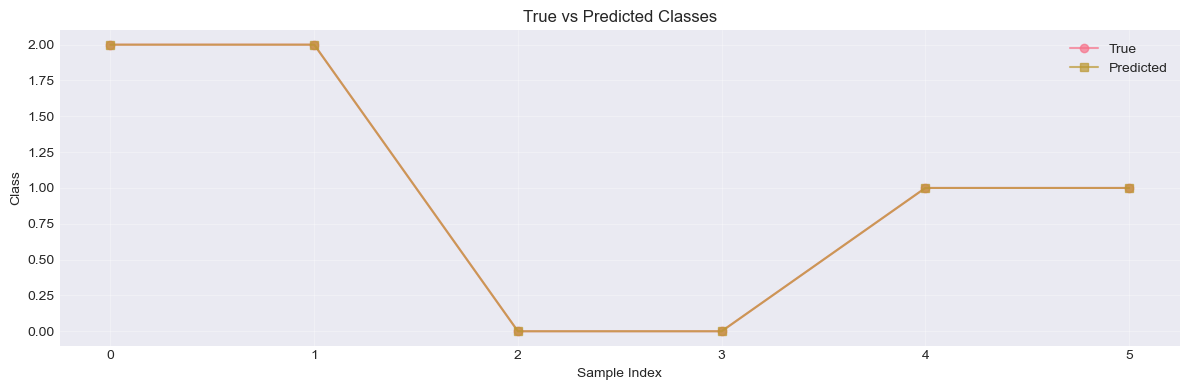

✅ Wykres zapisany: final_predictions.png


In [ ]:
# Finalne predykcje i wykresy
if 'ml_df' not in globals():
    print("⚠️ Uruchom najpierw KROK 6")
else:
    print("📊 Finalne predykcje...")
    X_final = ml_df.drop(columns=['regulation_score'], errors='ignore')
    y_final = regulation_df['regulation_class'].map({'słaba': 0, 'umiarkowana': 1, 'dobra': 2})
    le_final = LabelEncoder()
    y_final_enc = le_final.fit_transform(y_final)
    scaler_final = StandardScaler()
    X_final_scaled = scaler_final.fit_transform(X_final)
    model_final = RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
    model_final.fit(X_final_scaled, y_final_enc)
    y_pred_final = model_final.predict(X_final_scaled)
    fig, ax = plt.subplots(figsize=(12, 4))
    time_axis = np.arange(len(y_final_enc))
    ax.plot(time_axis, y_final_enc, 'o-', label='True', alpha=0.7)
    ax.plot(time_axis, y_pred_final, 's-', label='Predicted', alpha=0.7)
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Class')
    ax.set_title('True vs Predicted Classes')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('final_predictions.png', dpi=150)
    plt.show()
    print("✅ Wykres zapisany: final_predictions.png")


In [ ]:
# Sprawdź czy zmienne są zdefiniowane
if 'ml_df' not in globals() or 'pivot_df' not in globals() or 'regulation_df' not in globals():
    print("="*80)
    print("❌ BŁĄD: Zmienne ml_df, pivot_df lub regulation_df nie są zdefiniowane.")
    print("="*80)
    print("💡 INSTRUKCJA:")
    print("   1. Uruchom najpierw komórkę KROK 5 (Przetwarzanie sygnałów i ekstrakcja cech)")
    print("   2. Następnie uruchom komórkę KROK 6 (Agregacja danych i przygotowanie do ML)")
    print("   3. Dopiero potem uruchom tę komórkę (KROK 7 - Modele ML)")
    print("="*80)
    print("\n⚠️ Zatrzymuję wykonanie tej komórki. Uruchom najpierw KROK 6!")
else:
    print("✅ Wszystkie potrzebne zmienne są zdefiniowane. Kontynuuję...")

# Przygotuj X i y
X = ml_df.drop(columns=['regulation_score'], errors='ignore')
y_original = regulation_df['regulation_class'].map({'słaba': 0, 'umiarkowana': 1, 'dobra': 2})

# Minimalna liczba próbek na klasę (1 = nie usuwamy żadnych klas)
min_class_count = 1

            # LabelEncoder: fit na WSZYSTKICH danych przed split
# Dla LOSO nie używamy train_test_split, ale LabelEncoder będzie w każdym foldzie
            le_extended = LabelEncoder()
y = y_original  # Zostawiamy jako Series/array - LabelEncoder będzie w każdym foldzie
            y_encoded = le_extended.fit_transform(y_original)


# Grupy dla LOSO
            # Train/test split z zakodowanymi y
groups = pivot_df['subject'].values

print(f"📊 Dane do ML:")
print(f"   X shape: {X.shape}")
print(f"   y shape: {y.shape}")
print(f"   Classes: {y.value_counts().to_dict()}")

# LOSO Cross-Validation
logo = LeaveOneGroupOut()
subjects_list = groups

# Definicje modeli (funkcje tworzące nowe instancje)
def create_random_forest():
    return RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        random_state=RANDOM_SEED,
        n_jobs=-1
    )

def create_lightgbm(num_classes=None):
    # Model LightGBM - zgodny z przykładem użytkownika
    # num_classes - liczba klas (None = auto-detect)
    if num_classes is None or num_classes > 2:
        objective = 'multiclass'
        num_class = num_classes if num_classes is not None else None
    else:
        objective = 'binary'
        num_class = None
    
    return lgb.LGBMClassifier(
        objective=objective,
        num_class=num_class,
        n_estimators=1000,  # Większa liczba (early stopping zatrzyma wcześniej)
        learning_rate=0.05,
        num_leaves=31,
        random_state=RANDOM_SEED
    )

# Modele do porównania
models_config = {
    'RandomForest': create_random_forest,
    'LightGBM': create_lightgbm  # Będzie wywoływane z num_classes w pętli
}

results = []

for model_name, model_factory in models_config.items():
    print(f"\n{'='*80}")
    print(f"Trenuję: {model_name}")
    print(f"{'='*80}")
    
    fold_scores = []
    
    for fold_idx, (train_idx, test_idx) in enumerate(logo.split(X, y, groups)):
        test_subject = subjects_list[test_idx[0]]
        
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Skalowanie
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Utwórz nową instancję modelu dla każdego folda
        # Utwórz model (wszystkie modele używają już zakodowanego y przez le_global)
        model = model_factory()
        model.fit(X_train_scaled, y_train)
        y_test_for_metrics = y_test
        else:
            model = model_factory()
            model.fit(X_train_scaled, y_train)
            y_test_for_metrics = y_test
        
        # Predykcje
        # Predykcje (wszystkie modele używają już zakodowanego y)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)
        y_pred_for_metrics = y_pred
            y_pred = model.predict(X_test_scaled)
            y_proba = model.predict_proba(X_test_scaled)
            y_pred_for_metrics = y_pred
            # y_test_for_metrics jest już ustawione wcześniej (y_test)
        
        # Metryki
        acc = accuracy_score(y_test_for_metrics, y_pred_for_metrics)
        f1 = f1_score(y_test_for_metrics, y_pred_for_metrics, average='weighted')
        
        # ROC-AUC (dla multi-class)
        try:
            roc_auc = roc_auc_score(y_test_for_metrics, y_proba, multi_class='ovr', average='weighted')
        except:
            roc_auc = np.nan
        
        fold_scores.append({
            'model': model_name,
            'fold': fold_idx,
            'test_subject': test_subject,
            'accuracy': acc,
            'f1_score': f1,
            'roc_auc': roc_auc
        })
        
        print(f"   Fold {fold_idx+1} ({test_subject}): Acc={acc:.3f}, F1={f1:.3f}, ROC-AUC={roc_auc:.3f}")
    
    # Podsumowanie
    fold_df = pd.DataFrame(fold_scores)
    results.append(fold_df)
    
    print(f"\n   Średnie wyniki {model_name}:")
    print(f"      Accuracy: {fold_df['accuracy'].mean():.3f} ± {fold_df['accuracy'].std():.3f}")
    print(f"      F1-Score: {fold_df['f1_score'].mean():.3f} ± {fold_df['f1_score'].std():.3f}")
    print(f"      ROC-AUC: {fold_df['roc_auc'].mean():.3f} ± {fold_df['roc_auc'].std():.3f}")

# Porównanie modeli
all_results = pd.concat(results, ignore_index=True)
print(f"\n{'='*80}")
print("PODSUMOWANIE WYNIKÓW LOSO CV")
print(f"{'='*80}")
print(all_results.groupby('model')[['accuracy', 'f1_score', 'roc_auc']].agg(['mean', 'std']))

# Wybierz najlepszy model
best_model_name = all_results.groupby('model')['f1_score'].mean().idxmax()
print(f"\n✅ Najlepszy model: {best_model_name}")


IndentationError: unexpected indent (786161433.py, line 24)

In [ ]:
if HAS_SHAP:
    print("🔍 Analiza SHAP dla najlepszego modelu...")
    
    # Sprawdź czy wszystkie potrzebne zmienne są zdefiniowane
    if 'ml_df' not in globals() or 'regulation_df' not in globals():
        print("⚠️ Uruchom najpierw KROK 6 (Agregacja danych)")
    elif 'X' not in globals() or 'y' not in globals():
        print("⚠️ Uruchom najpierw KROK 7 (Modele ML)")
    else:
        # Definicje funkcji modeli (jeśli nie są zdefiniowane)
        if 'create_random_forest' not in globals():
            def create_random_forest():
                return RandomForestClassifier(n_estimators=500, max_depth=None, random_state=RANDOM_SEED, n_jobs=-1)
        
        if 'create_lightgbm' not in globals():
else:
    print("⚠️ SHAP nie jest dostępny. Zainstaluj: pip install shap")


IndentationError: expected an indented block after 'if' statement on line 15 (2305029143.py, line 16)

In [ ]:
# Sprawdź rozkład etykiet regulacji
if 'regulation_df' in globals():
    print("📊 Rozkład klas regulacji:")
    print(regulation_df['regulation_class'].value_counts())
elif 'pivot_df' in globals() and 'regulation_class' in pivot_df.columns:
    print("📊 Rozkład klas regulacji:")
    print(pivot_df['regulation_class'].value_counts())
else:
    print("⚠️ Uruchom najpierw KROK 6 (Agregacja danych), aby utworzyć regulation_df")

📊 Rozkład klas regulacji:
regulation_class
słaba          2
umiarkowana    2
dobra          2
Name: count, dtype: int64


In [ ]:
import sys
print(sys.executable)

/opt/anaconda3/bin/python


In [ ]:
if HAS_SHAP:
    print("🔍 Analiza SHAP dla najlepszego modelu...")
    
    # Sprawdź czy wszystkie potrzebne zmienne są zdefiniowane
    if 'ml_df' not in globals() or 'regulation_df' not in globals():
        print("⚠️ Uruchom najpierw KROK 6 (Agregacja danych)")
    elif 'X' not in globals() or 'y' not in globals():
        print("⚠️ Uruchom najpierw KROK 7 (Modele ML)")
    else:
        # Definicje funkcji modeli (jeśli nie są zdefiniowane)
        if 'create_random_forest' not in globals():
            def create_random_forest():
                return RandomForestClassifier(n_estimators=500, max_depth=None, random_state=RANDOM_SEED, n_jobs=-1)
        
        if 'create_lightgbm' not in globals():
else:
    print("⚠️ SHAP nie jest dostępny. Zainstaluj: pip install shap")


IndentationError: expected an indented block after 'if' statement on line 15 (2305029143.py, line 16)

In [ ]:
# Sprawdź czy zmienne są zdefiniowane
if 'y_test' not in globals() or 'y_train' not in globals():
    print("⚠️ Uruchom najpierw KROK 7 (modele ML z LOSO) lub KROK 7B (rozszerzone modele)")
    print("   Zmienne y_test i y_train nie są zdefiniowane.")
else:
    missing = set(y_test) - set(y_train)
    print(f"Klasy w test set, których nie ma w train set: {missing}")


⚠️ Uruchom najpierw KROK 7 (modele ML z LOSO) lub KROK 7B (rozszerzone modele)
   Zmienne y_test i y_train nie są zdefiniowane.


In [ ]:
# Sprawdź rozkład etykiet regulacji
if 'regulation_df' in globals():
    print("📊 Rozkład klas regulacji:")
    print(regulation_df['regulation_class'].value_counts())
elif 'pivot_df' in globals() and 'regulation_class' in pivot_df.columns:
    print("📊 Rozkład klas regulacji:")
    print(pivot_df['regulation_class'].value_counts())
else:
    print("⚠️ Uruchom najpierw KROK 6 (Agregacja danych), aby utworzyć regulation_df")

📊 Rozkład klas regulacji:
regulation_class
słaba          2
umiarkowana    2
dobra          2
Name: count, dtype: int64


In [ ]:
# Sprawdź czy zmienne są zdefiniowane
if 'original_df' not in globals():
    # Spróbuj użyć pivot_df lub ml_df jako fallback
    if 'pivot_df' in globals():
        df = pivot_df.copy()
        print("✅ Używam pivot_df (original_df nie jest zdefiniowane)")
    elif 'ml_df' in globals():
        df = ml_df.copy()
        print("✅ Używam ml_df (original_df nie jest zdefiniowane)")
    else:
        print("⚠️ Uruchom najpierw KROK 6, aby wygenerować dane")
        print("   Zmienne original_df, pivot_df i ml_df nie są zdefiniowane.")
        df = None
else:
    df = original_df.copy()


✅ Używam pivot_df (original_df nie jest zdefiniowane)


## KROK 8: Interpretacja modeli - SHAP Values

SHAP (SHapley Additive exPlanations) pokazuje, które cechy są najważniejsze dla predykcji.


In [57]:
if HAS_SHAP:
    print("🔍 Analiza SHAP dla najlepszego modelu...")
    
    # Sprawdź czy wszystkie potrzebne zmienne są zdefiniowane
    if 'ml_df' not in globals() or 'regulation_df' not in globals():
        print("⚠️ Uruchom najpierw KROK 6 (Agregacja danych)")
    elif 'X' not in globals() or 'y' not in globals():
        print("⚠️ Uruchom najpierw KROK 7 (Modele ML)")
    else:
        # Definicje funkcji modeli (jeśli nie są zdefiniowane)
        if 'create_random_forest' not in globals():
            def create_random_forest():
                return RandomForestClassifier(n_estimators=500, max_depth=None, random_state=RANDOM_SEED, n_jobs=-1)
        
        if 'create_lightgbm' not in globals():
else:
    print("⚠️ SHAP nie jest dostępny. Zainstaluj: pip install shap")


IndentationError: expected an indented block after 'if' statement on line 15 (2305029143.py, line 16)

## KROK 9: Wizualizacje wyników

Tworzymy profesjonalne wykresy: time series, radar charts, heatmaps, ROC curves.


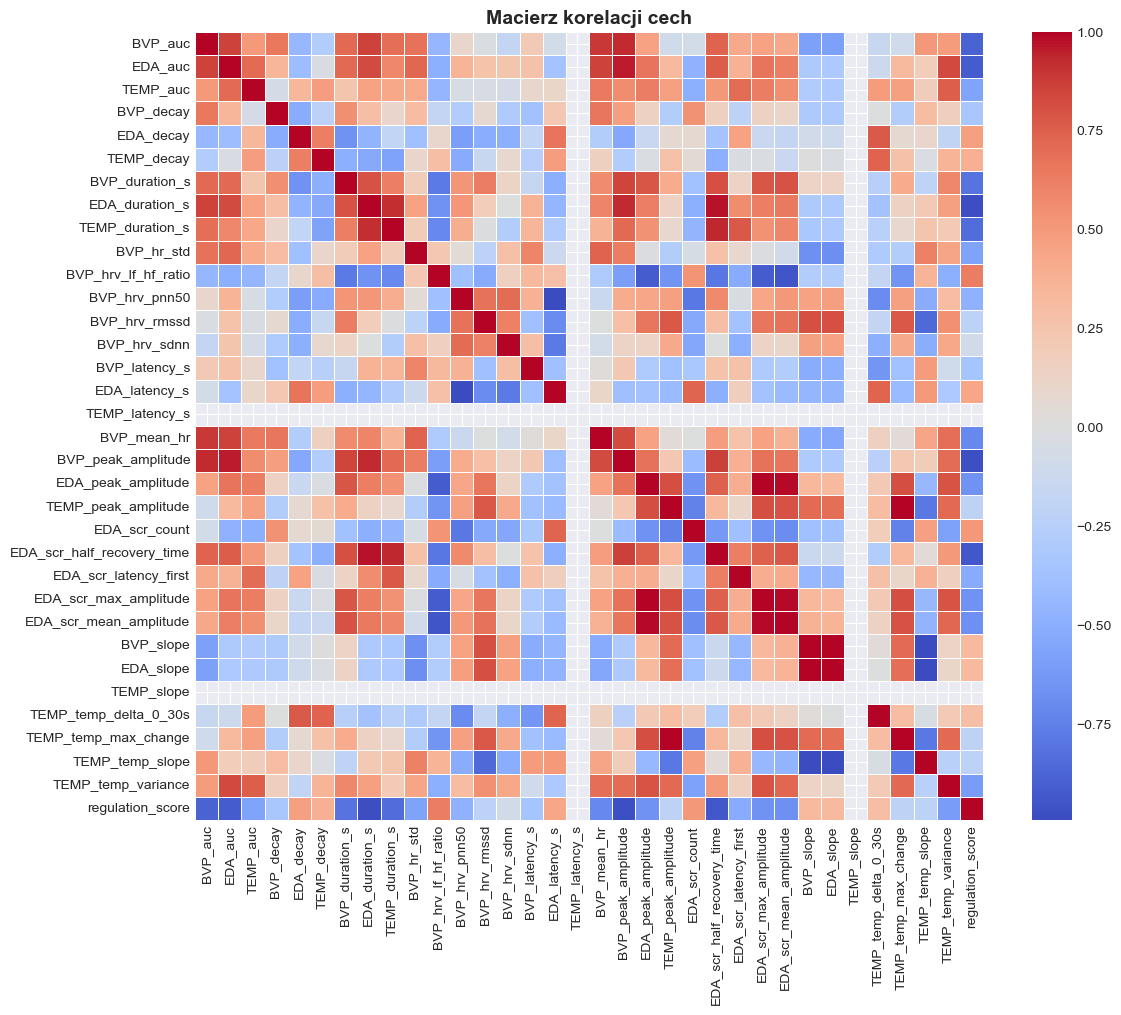

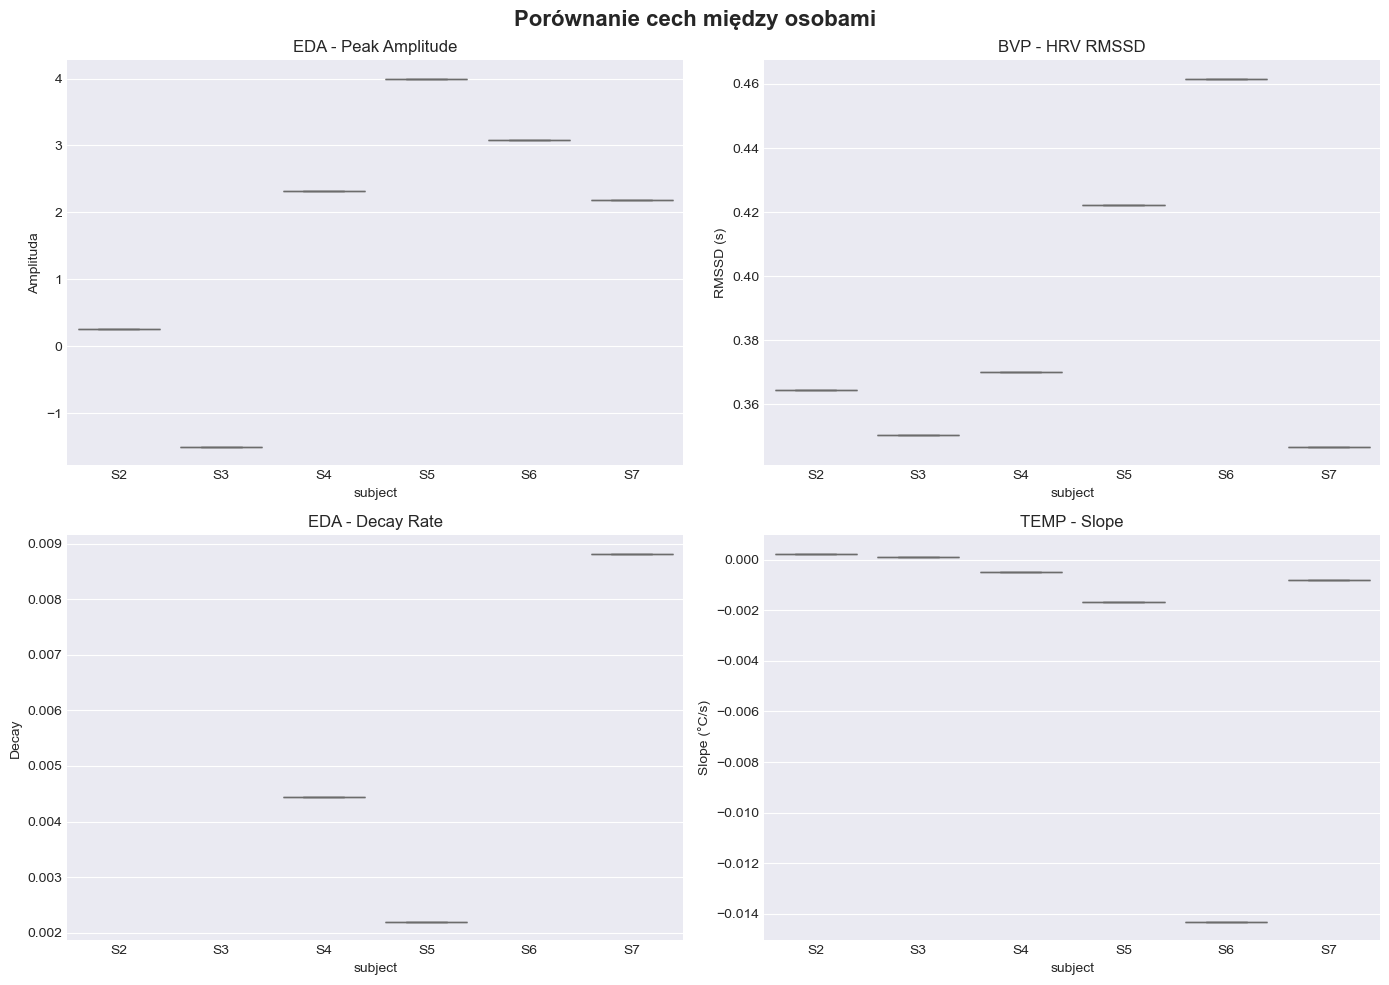

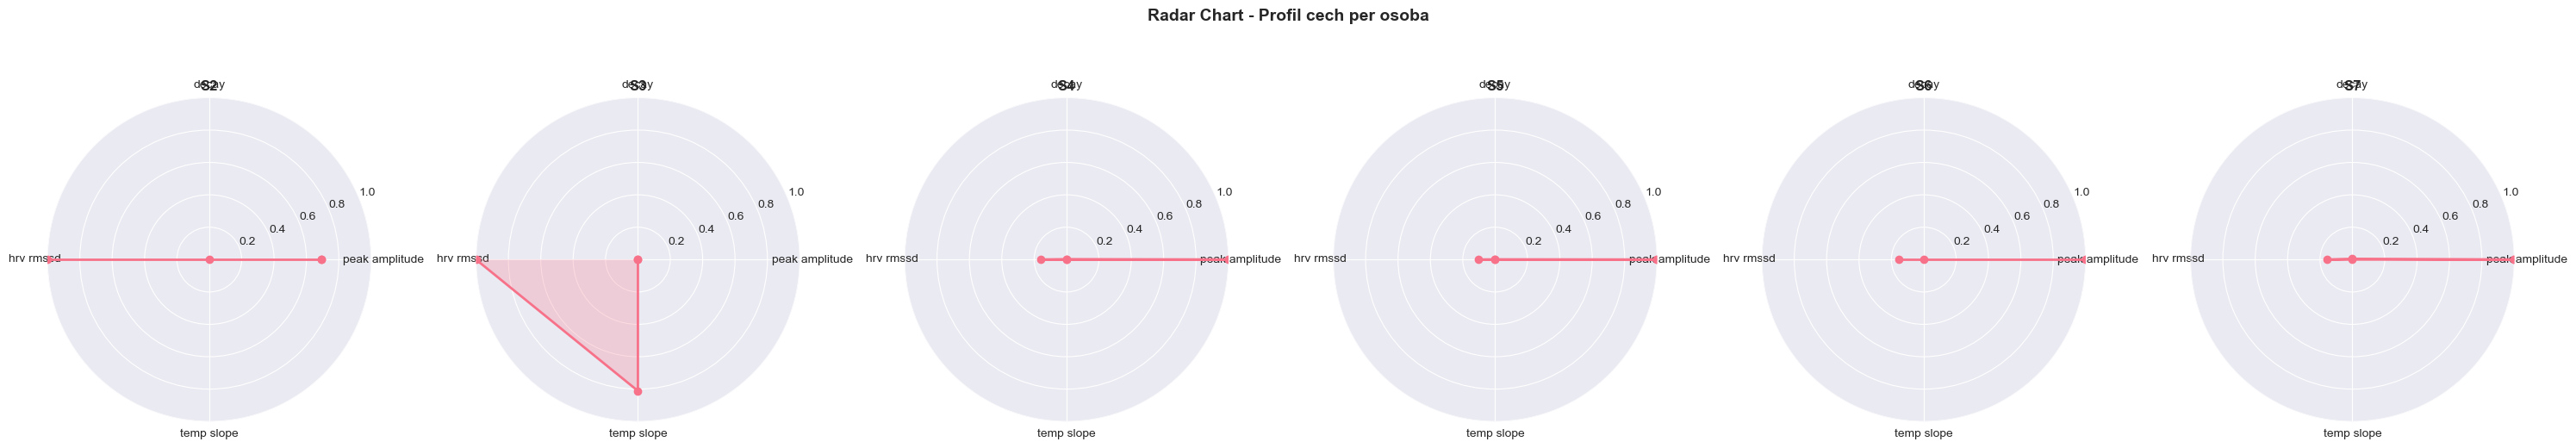

✅ Wizualizacje wygenerowane


In [58]:
# 1. Heatmapa korelacji cech
plt.figure(figsize=(12, 10))
corr_matrix = ml_df.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title('Macierz korelacji cech', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 2. Boxploty porównawcze dla wybranych cech
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Porównanie cech między osobami', fontsize=16, fontweight='bold')

# EDA peak amplitude
if 'EDA_peak_amplitude' in pivot_df.columns:
    sns.boxplot(data=pivot_df, x='subject', y='EDA_peak_amplitude', ax=axes[0, 0])
    axes[0, 0].set_title('EDA - Peak Amplitude')
    axes[0, 0].set_ylabel('Amplituda')

# BVP HRV RMSSD
if 'BVP_hrv_rmssd' in pivot_df.columns:
    sns.boxplot(data=pivot_df, x='subject', y='BVP_hrv_rmssd', ax=axes[0, 1])
    axes[0, 1].set_title('BVP - HRV RMSSD')
    axes[0, 1].set_ylabel('RMSSD (s)')

# EDA decay
if 'EDA_decay' in pivot_df.columns:
    sns.boxplot(data=pivot_df, x='subject', y='EDA_decay', ax=axes[1, 0])
    axes[1, 0].set_title('EDA - Decay Rate')
    axes[1, 0].set_ylabel('Decay')

# TEMP slope
if 'TEMP_temp_slope' in pivot_df.columns:
    sns.boxplot(data=pivot_df, x='subject', y='TEMP_temp_slope', ax=axes[1, 1])
    axes[1, 1].set_title('TEMP - Slope')
    axes[1, 1].set_ylabel('Slope (°C/s)')

plt.tight_layout()
plt.show()

# 3. Radar chart dla każdej osoby (jeśli mamy odpowiednie cechy)
# Wybierz kluczowe cechy do radar chart
key_features = ['EDA_peak_amplitude', 'EDA_decay', 'BVP_hrv_rmssd', 'TEMP_temp_slope']
available_features = [f for f in key_features if f in pivot_df.columns]

if len(available_features) >= 3:
    fig, axes = plt.subplots(1, len(pivot_df), figsize=(5*len(pivot_df), 5), subplot_kw=dict(projection='polar'))
    if len(pivot_df) == 1:
        axes = [axes]
    
    for idx, (subject, row) in enumerate(pivot_df.iterrows()):
        values = [row.get(f, 0) for f in available_features]
        # Normalizuj wartości do zakresu 0-1
        values_norm = [(v - min(values)) / (max(values) - min(values) + 1e-10) for v in values]
        
        angles = np.linspace(0, 2 * np.pi, len(available_features), endpoint=False).tolist()
        values_norm += values_norm[:1]  # Zamknij wykres
        angles += angles[:1]
        
        axes[idx].plot(angles, values_norm, 'o-', linewidth=2)
        axes[idx].fill(angles, values_norm, alpha=0.25)
        axes[idx].set_xticks(angles[:-1])
        axes[idx].set_xticklabels([f.replace('_', ' ').replace('EDA ', '').replace('BVP ', '').replace('TEMP ', '') for f in available_features])
        axes[idx].set_title(f'{row["subject"]}', fontweight='bold')
        axes[idx].set_ylim(0, 1)
    
    plt.suptitle('Radar Chart - Profil cech per osoba', fontsize=14, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()

print("✅ Wizualizacje wygenerowane")


## KROK 10: Interaktywny Streamlit Dashboard

Generujemy aplikację Streamlit z pełną funkcjonalnością analizy regulacji emocjonalnej.


In [59]:
from pathlib import Path

# Sprawdź czy plik CSV istnieje przed generowaniem Streamlit
csv_path = Path("wesad_features_full.csv")
if not csv_path.exists():
    print("=" * 80)
    print("⚠️ UWAGA: Plik wesad_features_full.csv nie istnieje!")
    print("=" * 80)
    print("💡 Uruchom najpierw KROK 6, aby wygenerować plik CSV.")
    print("=" * 80)
else:
    print(f"✅ Znaleziono plik: {csv_path.absolute()}")
    print(f"   Rozmiar: {csv_path.stat().st_size / 1024:.2f} KB")

# Kod aplikacji Streamlit
streamlit_code = '''import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# Konfiguracja strony
st.set_page_config(
    page_title="WESAD Full Pro Analysis",
    page_icon="🧠",
    layout="wide"
)

st.title("🧠 WESAD - Full Pro Analysis Dashboard")
st.markdown("---")

# Funkcja do wczytywania danych z obsługą błędów
@st.cache_data
def load_data():
    """Wczytuje dane z pliku CSV z pełną obsługą błędów"""
    csv_path = Path("wesad_features_full.csv")
    
    # Sprawdź czy plik istnieje
    if not csv_path.exists():
        st.error(f"❌ **Plik nie istnieje:** `{csv_path.absolute()}`")
        st.info("💡 **Rozwiązanie:** Uruchom KROK 6 w notebooku `wesad_full_pro_analysis.ipynb`")
        return None
    
    # Spróbuj wczytać plik
    try:
        df = pd.read_csv(csv_path)
        
        # Sprawdź czy plik nie jest pusty
        if len(df) == 0:
            st.error("❌ **Plik CSV jest pusty!**")
            st.info("💡 Uruchom ponownie KROK 6 w notebooku")
            return None
        
        # Sprawdź czy ma kolumnę 'subject'
        if 'subject' not in df.columns:
            st.error("❌ **Brak kolumny 'subject' w pliku CSV!**")
            st.info("💡 Sprawdź czy plik został poprawnie wygenerowany w KROK 6")
            st.code(f"Dostępne kolumny: {', '.join(df.columns[:10])}...")
            return None
        
        return df
        
    except pd.errors.EmptyDataError:
        st.error("❌ **Plik CSV jest pusty!**")
        return None
    except pd.errors.ParserError as e:
        st.error(f"❌ **Błąd parsowania pliku CSV:** {e}")
        st.info("💡 Sprawdź czy plik nie jest uszkodzony")
        return None
    except Exception as e:
        st.error(f"❌ **Nieoczekiwany błąd:** {type(e).__name__}: {e}")
        st.exception(e)
        return None

# Wczytaj dane
df = load_data()

# Główna aplikacja
if df is not None:
    try:
        # Sidebar
        st.sidebar.header("⚙️ Konfiguracja")
        
        # Pobierz listę subjectów
        subjects = df['subject'].unique().tolist()
        subjects.sort()  # Posortuj alfabetycznie
        
        if len(subjects) == 0:
            st.error("❌ **Brak subjectów w danych!**")
        else:
            # Wybór subjecta
            selected_subject = st.sidebar.selectbox(
                "Wybierz osobę:",
                subjects,
                index=0
            )
            
            # Filtruj dane dla wybranego subjecta
            subject_data = df[df['subject'] == selected_subject]
            
            if len(subject_data) == 0:
                st.error(f"❌ **Brak danych dla subjecta {selected_subject}!**")
            else:
                subject_data = subject_data.iloc[0]
                
                # ========== GŁÓWNE METRYKI ==========
                st.header(f"📊 Analiza dla {selected_subject}")
                
                col1, col2, col3, col4 = st.columns(4)
                
                with col1:
                    eda_amp = subject_data.get('EDA_peak_amplitude', np.nan)
                    if not np.isnan(eda_amp):
                        st.metric("EDA Amplitude", f"{eda_amp:.3f}")
                    else:
                        st.metric("EDA Amplitude", "N/A")
                
                with col2:
                    hrv_rmssd = subject_data.get('BVP_hrv_rmssd', np.nan)
                    if not np.isnan(hrv_rmssd):
                        st.metric("HRV RMSSD", f"{hrv_rmssd:.3f}")
                    else:
                        st.metric("HRV RMSSD", "N/A")
                
                with col3:
                    eda_decay = subject_data.get('EDA_decay', np.nan)
                    if not np.isnan(eda_decay):
                        st.metric("EDA Decay", f"{eda_decay:.3f}")
                    else:
                        st.metric("EDA Decay", "N/A")
                
                with col4:
                    regulation_class = subject_data.get('regulation_class', 'N/A')
                    st.metric("Regulacja", regulation_class)
                
                # ========== WIZUALIZACJE ==========
                st.markdown("---")
                st.subheader("📈 Wizualizacje cech")
                
                try:
                    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
                    
                    # EDA features
                    eda_cols = [col for col in df.columns if col.startswith('EDA_') and col != 'EDA_peak_index']
                    if len(eda_cols) > 0:
                        eda_values = [subject_data.get(col, 0) for col in eda_cols[:5]]
                        axes[0, 0].bar(range(len(eda_values)), eda_values)
                        axes[0, 0].set_xticks(range(len(eda_values)))
                        axes[0, 0].set_xticklabels(
                            [col.replace('EDA_', '') for col in eda_cols[:5]], 
                            rotation=45, 
                            ha='right'
                        )
                        axes[0, 0].set_title('EDA Features')
                        axes[0, 0].grid(True, alpha=0.3)
                    else:
                        axes[0, 0].text(0.5, 0.5, 'Brak danych EDA', 
                                       ha='center', va='center', transform=axes[0, 0].transAxes)
                        axes[0, 0].set_title('EDA Features')
                    
                    # BVP/HRV features
                    bvp_cols = [col for col in df.columns if col.startswith('BVP_')]
                    if len(bvp_cols) > 0:
                        bvp_values = [subject_data.get(col, 0) for col in bvp_cols[:5]]
                        axes[0, 1].bar(range(len(bvp_values)), bvp_values)
                        axes[0, 1].set_xticks(range(len(bvp_values)))
                        axes[0, 1].set_xticklabels(
                            [col.replace('BVP_', '') for col in bvp_cols[:5]], 
                            rotation=45, 
                            ha='right'
                        )
                        axes[0, 1].set_title('BVP/HRV Features')
                        axes[0, 1].grid(True, alpha=0.3)
                    else:
                        axes[0, 1].text(0.5, 0.5, 'Brak danych BVP', 
                                       ha='center', va='center', transform=axes[0, 1].transAxes)
                        axes[0, 1].set_title('BVP/HRV Features')
                    
                    # Porównanie z innymi
                    if 'EDA_peak_amplitude' in df.columns:
                        axes[1, 0].bar(df['subject'], df['EDA_peak_amplitude'])
                        axes[1, 0].axhline(
                            y=subject_data.get('EDA_peak_amplitude', 0), 
                            color='r', 
                            linestyle='--', 
                            label='Wybrana osoba'
                        )
                        axes[1, 0].set_title('EDA Peak Amplitude - Porównanie')
                        axes[1, 0].set_ylabel('Amplituda')
                        axes[1, 0].legend()
                        axes[1, 0].grid(True, alpha=0.3)
                    else:
                        axes[1, 0].text(0.5, 0.5, 'Brak danych', 
                                       ha='center', va='center', transform=axes[1, 0].transAxes)
                    
                    # Regulation class distribution
                    if 'regulation_class' in df.columns:
                        regulation_counts = df['regulation_class'].value_counts()
                        axes[1, 1].bar(regulation_counts.index, regulation_counts.values)
                        axes[1, 1].set_title('Rozkład klas regulacji')
                        axes[1, 1].set_ylabel('Liczba osób')
                        axes[1, 1].grid(True, alpha=0.3)
                    else:
                        axes[1, 1].text(0.5, 0.5, 'Brak danych', 
                                       ha='center', va='center', transform=axes[1, 1].transAxes)
                    
                    plt.tight_layout()
                    st.pyplot(fig, use_container_width=True)
                    
                except Exception as e:
                    st.error(f"❌ **Błąd podczas tworzenia wykresów:** {e}")
                    st.exception(e)
                
                # ========== TABELA Z CECHAMI (WIDOK TRANSPONOWANY) ==========
                st.markdown("---")
                st.subheader("📊 Wszystkie cechy (Cecha → Wartość)")
                
                try:
                    # Wyświetl w formie transponowanej (cecha -> wartość)
                    transposed_df = subject_data.to_frame().T
                    if 'subject' in transposed_df.columns:
                        transposed_df = transposed_df.drop(columns=['subject'])
                    st.dataframe(transposed_df, width='stretch', hide_index=True)
                        
                except Exception as e:
                    st.error(f"❌ **Błąd podczas wyświetlania tabeli:** {e}")
                    st.exception(e)
                
                # ========== PREDYKCJA REGULACJI ==========
                st.markdown("---")
                st.subheader("🔮 Predykcja Regulacji Emocjonalnej")
                
                if st.button("🎯 Uruchom Analizę", type="primary"):
                    regulation_class = subject_data.get('regulation_class', 'N/A')
                    
                    if regulation_class == 'dobra':
                        st.success("✅ **Dobra regulacja emocjonalna** - szybko wracasz do równowagi!")
                    elif regulation_class == 'umiarkowana':
                        st.warning("⚠️ **Umiarkowana regulacja** - możesz poprawić strategie regulacji.")
                    elif regulation_class == 'słaba':
                        st.error("❌ **Słaba regulacja** - rozważ techniki relaksacyjne i wsparcie.")
                    else:
                        st.info("ℹ️ Analiza w toku...")
    
    except Exception as e:
        st.error(f"❌ **Krytyczny błąd aplikacji:** {type(e).__name__}: {e}")
        st.exception(e)
        st.info("💡 **Spróbuj:**")
        st.info("1. Odśwież stronę (F5)")
        st.info("2. Sprawdź czy plik CSV jest poprawny")
        st.info("3. Uruchom ponownie KROK 6 w notebooku")

else:
    # Instrukcje gdy nie ma danych
    st.error("❌ **Nie można wczytać danych**")
    st.markdown("---")
    st.info("💡 **Instrukcja rozwiązania problemu:**")
    st.markdown("""
    1. **Otwórz notebook:** `wesad_full_pro_analysis.ipynb`
    2. **Uruchom komórki w kolejności:**
       - KROK 1: Import bibliotek
       - KROK 2: Funkcje pomocnicze
       - KROK 3: Ekstrakcja cech
       - KROK 5: Przetwarzanie sygnałów
       - KROK 6: Agregacja danych (generuje plik CSV)
    3. **Sprawdź czy plik został utworzony:**
       - `wesad_features_full.csv` w tym samym katalogu
    4. **Uruchom ponownie aplikację Streamlit**
    """)
    
    # Pokaż informacje o systemie
    with st.expander("🔍 Informacje diagnostyczne"):
        st.code(f"""
Python: {sys.version}
Katalog roboczy: {Path.cwd()}
Plik CSV: {Path('wesad_features_full.csv').absolute()}
Istnieje: {Path('wesad_features_full.csv').exists()}
        """)
'''

# Zapisz aplikację
streamlit_app_path = "wesad_full_pro_streamlit_app.py"
app_full_path = Path(streamlit_app_path).absolute()

# Zapisz aplikację
with open(streamlit_app_path, 'w', encoding='utf-8') as f:
    f.write(streamlit_code)

print("=" * 80)
print("✅ APLIKACJA STREAMLIT ZAPISANA!")
print("=" * 80)
print(f"\n📁 Plik aplikacji: {streamlit_app_path}")
print(f"📁 Pełna ścieżka: {app_full_path}")

print(f"\n{'='*80}")
print("📋 INSTRUKCJA URUCHOMIENIA - SKOPIUJ TE DWIE LINIE DO TERMINALA:")
print(f"{'='*80}")
print(f"\ncd \"{Path.cwd()}\"")
print(f"streamlit run {streamlit_app_path}")
print(f"\n{'='*80}")
print("💡 Aplikacja otworzy się w przeglądarce pod adresem: http://localhost:8501")
print(f"{'='*80}")


✅ Znaleziono plik: /Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/notebooks/wesad_features_full.csv
   Rozmiar: 3.42 KB
✅ APLIKACJA STREAMLIT ZAPISANA!

📁 Plik aplikacji: wesad_full_pro_streamlit_app.py
📁 Pełna ścieżka: /Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/notebooks/wesad_full_pro_streamlit_app.py

📋 INSTRUKCJA URUCHOMIENIA - SKOPIUJ TE DWIE LINIE DO TERMINALA:

cd "/Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/notebooks"
streamlit run wesad_full_pro_streamlit_app.py

💡 Aplikacja otworzy się w przeglądarce pod adresem: http://localhost:8501
